# Starbucks Capstone Challenge

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [54]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Understanding & Data Pre-Processing

- `portfolio`

In [16]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [17]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [18]:
# get channel portfolios 
channels = set(channel for i in range(portfolio.shape[0]) for channel in portfolio.iloc[i,1] )

In [19]:
# One hot encode channels data 
for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio = portfolio.drop('channels', axis = 1) 
portfolio.head()

,reward,difficulty,duration,offer_type,id,web,mobile,social,email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


- `profile`

In [55]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [56]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [57]:
# Fill empty gender values with unknown
profile['gender'] = profile['gender'].fillna('Unknown')

In [58]:
# Fill empty income values with mean value
income_mean = profile['income'].mean() 
profile['income'] = profile['income'].fillna(income_mean)

/Users/ziyuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


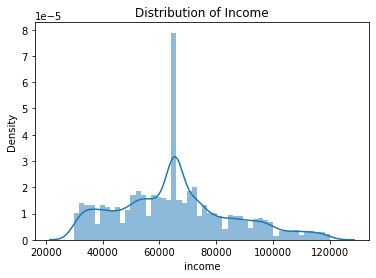

In [59]:
fig, ax = plt.subplots()
sns.distplot(profile['income'], bins=50, hist_kws={'alpha': 0.5}, ax=ax)
plt.title('Distribution of Income');

In [60]:
#Dropping became_member_on column, and creating new columns representing year,month,date, and member_date
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['became_member_on'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.head()

,gender,age,id,became_member_on,income,member_year,member_month,member_day
0,Unknown,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,2017,7,15
2,Unknown,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,2017,5,9
4,Unknown,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,2017,8,4


In [61]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            17000 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            17000 non-null  float64       
 5   member_year       17000 non-null  int64         
 6   member_month      17000 non-null  int64         
 7   member_day        17000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 1.0+ MB


In [62]:
profile.groupby(['gender']).id.count()

gender
F          6129
M          8484
O           212
Unknown    2175
Name: id, dtype: int64

In [63]:
profile.groupby(['age']).id.count()

age
18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: id, Length: 85, dtype: int64

From above, we can see that if a customer doesnt give their gender, their age will be set as a default number with is 118. Therefore, We want to reset the age with 118 into 'Unknown' and then group the customers into age group (18-25, 26-35, 36-45, 46-55, 56-65, >65, Unknown).

In [102]:
def split_into_age_group(df, bins):
    age_bucket_labels = []
    for i, bin in enumerate(bins):
        if i == 0:
            label = f"18-{bin}"
        elif i == len(bins) - 2:
            label = f"{bin}-"
            break
        else:
            label = f"{bins[i-1]}-{bin}"
        age_bucket_labels.append(label)
    age_bucket_labels.append("118")
    df["age_bucket"] = pd.cut(df["age"], bins=bins, labels=age_bucket_labels)
    df["age_bucket"] = df["age_bucket"].replace("118", "Unknown")
    return df

In [106]:
bins = [17,24, 34, 44, 54, 64, 117, 1000]
cleaned_profile = split_into_age_group(profile, bins=bins)

In [107]:
cleaned_profile.groupby(['age_bucket']).id.count()

age_bucket
18-17       876
17-24      1380
24-34      1869
34-44      3013
44-54      3421
54-64      4266
Unknown    2175
Name: id, dtype: int64

In [108]:
cleaned_profile.count()

gender              17000
age                 17000
id                  17000
became_member_on    17000
income              17000
member_year         17000
member_month        17000
member_day          17000
age_bucket          17000
dtype: int64

- `transcript`

In [12]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [13]:
# Split value column into value_type and value
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 
transcript.head()

,person,event,value,time,value_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer id
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer id
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer id
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer id
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer id


In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   person      306534 non-null  object
 1   event       306534 non-null  object
 2   value       306534 non-null  object
 3   time        306534 non-null  int64 
 4   value_type  306534 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.7+ MB


In [15]:
transcript.groupby(['value_type', 'event']).count()

person   value    time
value_type event                                  
amount     transaction      138953  138953  138953
offer id   offer received    76277   76277   76277
           offer viewed      57725   57725   57725
offer_id   offer completed   33579   33579   33579

In [16]:
transcript['value_type'] = transcript['value_type'].replace('offer id', 'offer_id')

In [17]:
transcript.groupby(['value_type', 'event']).count()

person   value    time
value_type event                                  
amount     transaction      138953  138953  138953
offer_id   offer completed   33579   33579   33579
           offer received    76277   76277   76277
           offer viewed      57725   57725   57725

In [18]:
transcript[transcript["event"]=='offer completed']

,person,event,value,time,value_type
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id
12679,629fc02d56414d91bca360decdfa9288,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id
12692,676506bad68e4161b9bbaffeb039626b,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,0,offer_id
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id
...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,714,offer_id
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,714,offer_id
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,fafdcd668e3743c1bb461111dcafc2a4,714,offer_id
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,fafdcd668e3743c1bb461111dcafc2a4,714,offer_id


In [111]:
cleaned_transcript[cleaned_transcript.person == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,person,event,value,time,value_type
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer viewed,2906b810c7d4411798c6938adc9daaa5,0,offer_id
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,34.56,0,amount
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,2906b810c7d4411798c6938adc9daaa5,0,offer_id
27850,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,21.55,42,amount
44327,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,32.87,114,amount
51350,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,19.99,156,amount
65854,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,20.97,168,amount
81403,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,31.09,204,amount
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,336,offer_id


In [112]:
offer_received = cleaned_transcript[cleaned_transcript["event"]=='offer received']

### The average transaction value before a customer received an offer can also be an important feature to influence whether a customer will react to an offer.

In [113]:
transactions = cleaned_transcript[cleaned_transcript["event"]=='transaction']
transactions['value'] = transactions['value'].apply(lambda x: float(x))
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138953 entries, 12654 to 306533
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   person      138953 non-null  object 
 1   event       138953 non-null  object 
 2   value       138953 non-null  float64
 3   time        138953 non-null  int64  
 4   value_type  138953 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 6.4+ MB


<ipython-input-113-fe6a9bdc5a59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['value'] = transactions['value'].apply(lambda x: float(x))


In [116]:
# rank the time
transactions = (transactions.assign(rn=transactions.groupby(['person'])['time']
                    .rank(method='first', ascending=True))
                    .sort_values(['person', 'time']))
transactions.head()

,person,event,value,time,value_type,rn
89291,0009655768c64bdeb2e877511632db8f,transaction,22.16,228,amount,1.0
168412,0009655768c64bdeb2e877511632db8f,transaction,8.57,414,amount,2.0
228422,0009655768c64bdeb2e877511632db8f,transaction,14.11,528,amount,3.0
237784,0009655768c64bdeb2e877511632db8f,transaction,13.56,552,amount,4.0
258883,0009655768c64bdeb2e877511632db8f,transaction,10.27,576,amount,5.0


In [118]:
# get the sum of total transactions
transactions = (transactions.assign(total=transactions.sort_values(['time'])
                                .groupby(['person'])
                                .value
                                .cumsum())
                                .sort_values(['person', 'time']))
transactions['avg_amount'] = transactions['total'] / transactions['rn']
transactions.head()

,person,event,value,time,value_type,rn,total,avg_amount
89291,0009655768c64bdeb2e877511632db8f,transaction,22.16,228,amount,1.0,22.16,22.160000
168412,0009655768c64bdeb2e877511632db8f,transaction,8.57,414,amount,2.0,30.73,15.365000
228422,0009655768c64bdeb2e877511632db8f,transaction,14.11,528,amount,3.0,44.84,14.946667
237784,0009655768c64bdeb2e877511632db8f,transaction,13.56,552,amount,4.0,58.40,14.600000
258883,0009655768c64bdeb2e877511632db8f,transaction,10.27,576,amount,5.0,68.67,13.734000


In [127]:
offer_received = cleaned_transcript[cleaned_transcript["event"]=='offer received']
offer_received = offer_received.drop('value_type', axis=1)
offer_received.columns = ['person', 'event', 'offer_id', 'received_time']
offer_received.head()

,person,event,offer_id,received_time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0


In [155]:
# only the 
df = pd.merge(offer_received, transactions, on='person')
df = df[(df["received_time"] >= df["time"]) | (df["received_time"]==0)]

In [156]:
df[df.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event_x,offer_id,received_time,event_y,value,time,value_type,rn,total,avg_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,19.89,132,amount,1.0,19.89,19.890000
1,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,17.78,144,amount,2.0,37.67,18.835000
2,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,19.67,222,amount,3.0,57.34,19.113333
3,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,29.72,240,amount,4.0,87.06,21.765000
4,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,23.93,378,amount,5.0,110.99,22.198000
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,21.72,510,amount,6.0,132.71,22.118333
6,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,26.56,534,amount,7.0,159.27,22.752857
7,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168,transaction,19.89,132,amount,1.0,19.89,19.890000
8,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168,transaction,17.78,144,amount,2.0,37.67,18.835000
14,78afa995795e4d85b5d9ceeca43f5fef,offer received,ae264e3637204a6fb9bb56bc8210ddfd,408,transaction,19.89,132,amount,1.0,19.89,19.890000


In [157]:
# check result
df[df.person=='0009655768c64bdeb2e877511632db8f']

,person,event_x,offer_id,received_time,event_y,value,time,value_type,rn,total,avg_amount
536400,0009655768c64bdeb2e877511632db8f,offer received,3f207df678b143eea3cee63160fa8bed,336,transaction,22.16,228,amount,1.0,22.16,22.160000
536408,0009655768c64bdeb2e877511632db8f,offer received,f19421c1d4aa40978ebb69ca19b0e20d,408,transaction,22.16,228,amount,1.0,22.16,22.160000
536416,0009655768c64bdeb2e877511632db8f,offer received,fafdcd668e3743c1bb461111dcafc2a4,504,transaction,22.16,228,amount,1.0,22.16,22.160000
536417,0009655768c64bdeb2e877511632db8f,offer received,fafdcd668e3743c1bb461111dcafc2a4,504,transaction,8.57,414,amount,2.0,30.73,15.365000
536424,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,576,transaction,22.16,228,amount,1.0,22.16,22.160000
536425,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,576,transaction,8.57,414,amount,2.0,30.73,15.365000
536426,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,576,transaction,14.11,528,amount,3.0,44.84,14.946667
536427,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,576,transaction,13.56,552,amount,4.0,58.40,14.600000
536428,0009655768c64bdeb2e877511632db8f,offer received,2906b810c7d4411798c6938adc9daaa5,576,transaction,10.27,576,amount,5.0,68.67,13.734000


In [162]:
# only choose last transaction record for each offer received record
df1 = df[df.received_time!=0].loc[df[df.received_time!=0].groupby(['person', "received_time"])["time"].idxmax()]

In [163]:
# only choose last transaction record for each offer received record
df2 = df[df.received_time==0].loc[df[df.received_time==0].groupby(['person', "received_time"])["time"].idxmin()]

In [160]:
#check the result
df[df.person=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event_x,offer_id,received_time,event_y,value,time,value_type,rn,total,avg_amount
6,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,transaction,26.56,534,amount,7.0,159.27,22.752857
8,78afa995795e4d85b5d9ceeca43f5fef,offer received,5a8bc65990b245e5a138643cd4eb9837,168,transaction,17.78,144,amount,2.0,37.67,18.835000
18,78afa995795e4d85b5d9ceeca43f5fef,offer received,ae264e3637204a6fb9bb56bc8210ddfd,408,transaction,23.93,378,amount,5.0,110.99,22.198000
25,78afa995795e4d85b5d9ceeca43f5fef,offer received,f19421c1d4aa40978ebb69ca19b0e20d,504,transaction,23.93,378,amount,5.0,110.99,22.198000


## what are the characterics of ppl who have no transactions at all??!

In [176]:
def horizontal_bar_plot(df, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltfigsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

In [168]:
no_transactions = set(offer_received.person)- set(transactions.person)
len(no_transactions)

422

In [173]:
no_transactions_profile = cleaned_profile[cleaned_profile.id.isin(no_transactions)]
no_transactions_profile.head()

,gender,age,id,became_member_on,income,member_year,member_month,member_day,age_bucket
6,Unknown,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,65404.991568,2017,9,25,Unknown
90,F,70,13b7b2eccf664a329d83d2a238a9a11d,2018-06-13,74000.000000,2018,6,13,54-117
92,F,62,ffc6c9fbe34b4578911dcdf6745b4c74,2018-04-10,57000.000000,2018,4,10,44-64
202,M,81,accec36a10704e1fbaeb9b28b8bc5da8,2018-05-03,93000.000000,2018,5,3,54-117
219,F,79,688e4f2487d44ad8bbcc0f96936f42d6,2018-07-11,106000.000000,2018,7,11,54-117


<Figure size 360x360 with 0 Axes>

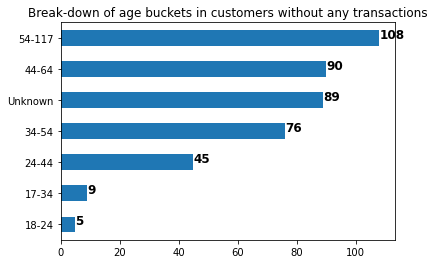

In [177]:
horizontal_bar_plot(no_transactions_profile, 'age_bucket', "Break-down of age buckets in customers without any transactions")

<Figure size 360x360 with 0 Axes>

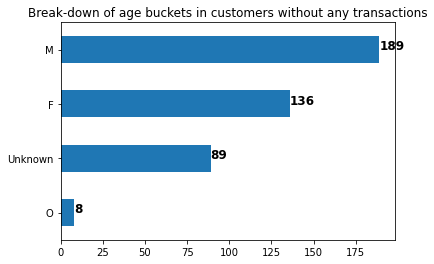

In [178]:
horizontal_bar_plot(no_transactions_profile, 'gender', "Break-down of age buckets in customers without any transactions")

/Users/ziyuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


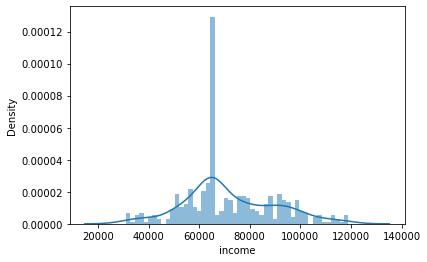

In [181]:
fig, ax = plt.subplots()
sns.distplot(no_transactions_profile['income'], bins=50, hist_kws={'alpha': 0.5}, ax=ax)
plt.show()

**Assumption:** if a customer has completed a specific offer at least one time, then we say this customer will also complete this specific offer next time

In [19]:
offer_completed = transcript[transcript["event"]=='offer completed']
offer_received = transcript[transcript["event"]=='offer received']
offer_received['completed'] = 0
completed_person = set(offer_completed['person'])
completed_value = set(offer_completed['value'])
for idx, row in offer_received.iterrows():
    if row['person'] in completed_person and row['value'] in completed_value:
        offer_received.loc[idx,'completed'] = 1
offer_received.head()

<ipython-input-19-e771395bb512>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_received['completed'] = 0
/Users/ziyuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,person,event,value,time,value_type,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer_id,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer_id,0
2,e2127556f4f64592b11af22de27a7932,offer received,2906b810c7d4411798c6938adc9daaa5,0,offer_id,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,fafdcd668e3743c1bb461111dcafc2a4,0,offer_id,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,0,offer_id,0


In [20]:
offer_received.groupby('completed').count()

,person,event,value,time,value_type
completed,,,,,
0,29198,29198,29198,29198,29198
1,47079,47079,47079,47079,47079


In [21]:
# Add info from profile to the df_all
df_all = pd.merge(offer_received[['person', 'value', 'completed']], profile[['id','gender','income', 'member_year', 'member_month']]
                                         , how='inner', left_on='person',right_on='id')

In [22]:
# Add info from portfolio to the df_all
df_all = pd.merge(df_all, portfolio, how='inner', left_on='value',right_on='id')

In [23]:
df_all[df_all['offer_type'] == 'informational'].completed.describe()

count    15235.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: completed, dtype: float64

In [25]:
# delete the offer_type == 'informational'
df_all = df_all[df_all['offer_type'] != 'informational']

In [26]:
df_all = df_all.drop(['id_x', 'id_y'], axis=1)

In [27]:
df_all.head()

,person,value,completed,gender,income,member_year,member_month,reward,difficulty,duration,offer_type,mobile,social,web,email
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,F,100000.000000,2017,5,5,5,7,bogo,1,0,1,1
1,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,M,70000.000000,2018,4,5,5,7,bogo,1,0,1,1
2,68617ca6246f4fbc85e91a2a49552598,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,Unknown,65404.991568,2017,10,5,5,7,bogo,1,0,1,1
3,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,M,53000.000000,2018,2,5,5,7,bogo,1,0,1,1
4,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,M,53000.000000,2018,2,5,5,7,bogo,1,0,1,1


In [28]:
df_all[df_all.duplicated()==True].count()

person          10405
value           10405
completed       10405
gender          10405
income          10405
member_year     10405
member_month    10405
reward          10405
difficulty      10405
duration        10405
offer_type      10405
mobile          10405
social          10405
web             10405
email           10405
dtype: int64

In [29]:
df_all = df_all.drop_duplicates()

In [30]:
df_all[df_all.duplicated()==True].count()

person          0
value           0
completed       0
gender          0
income          0
member_year     0
member_month    0
reward          0
difficulty      0
duration        0
offer_type      0
mobile          0
social          0
web             0
email           0
dtype: int64

In [31]:
df_all.shape

(50637, 15)

<a id='Data Analysis'></a>
###  Exploratory Data Analysis (EDA)

In [32]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_style("whitegrid", {"axes.grid": False})
sns.set_context("notebook")  # "talk", "notebook"

In [ ]:
def barplot(df, plt_type, x_col, y_col, plt_title, hue=None, fnt_size=12, fnt_weight='bold'):
    """
    This function creates a bar plot with the mean of a feature for categories
    
    Arguments:
    df: The dataframe with categories
    plt_type: The type of plot (it could be 'lineplot', 'barplot')
    x_col: The name of the column containing the categories
    y_col: The name of the column whose mean should be the y-axis
    plt_title: The plot title
    hue: The name of the column of hue    
    fnt_size: The font size of text (default to 12 point font size)
    fnt_weight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns:
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_mean = df.groupby(x_col)[y_col].mean()
    if plt_type = 'lineplot':
        sns.lineplot(data=df, x=x_col, y=y_col, hue=hue)
    if plt_type = 'lineplot':
        sns.barplot(data=df, x=x_col, y=y_col, hue=hue)
    for i, v in enumerate(y_mean):
        ax.text(v, i, str(v), color='black', fontsize=fnt_size, fontweight=fnt_weight)
    plt.title(plt_title)

#### 1. Customer features vs. offer completed

- Relationships between income and offer completed

<AxesSubplot:xlabel='income', ylabel='completed'>

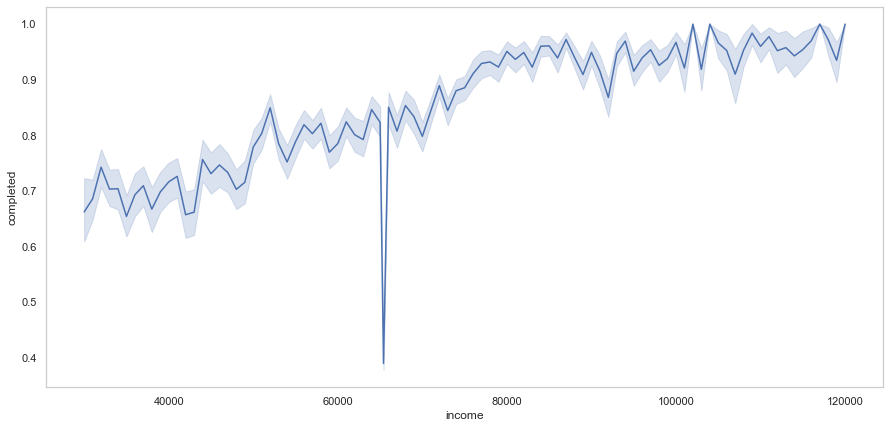

In [33]:
sns.lineplot(data=df_all, x="income", y="completed")

**Insight:** There is a positive relationship between income and completion ratio.

- Relationships between became_member's year & month vs. offer completed

<AxesSubplot:xlabel='member_year'>

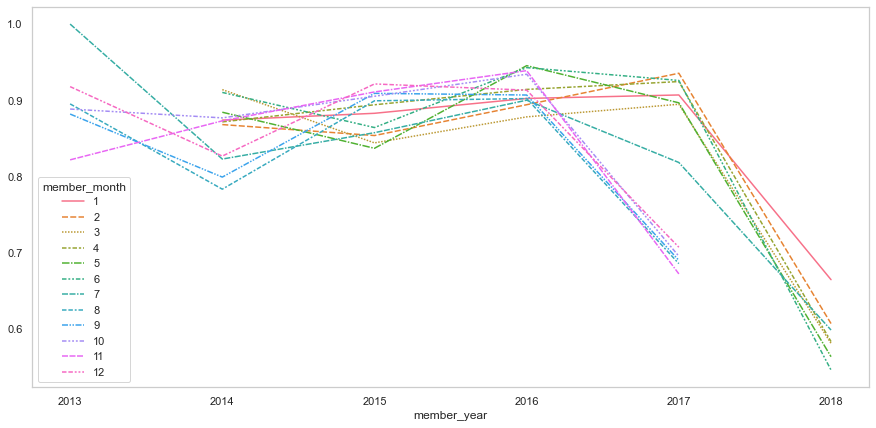

In [34]:
table = pd.pivot_table(df_all, values='completed', index=['member_year'],
                    columns=['member_month'], aggfunc=np.mean)
sns.lineplot(data=table)

**Insight:** The customers who became the members earlier ( before 2016) have in general higher completion ratio than the newer customers. However, the reason can be the customer loyalty but can also be that we have less data of the newer customers and can also be that our assumption at the start that 'if a customer has completed a specific offer at least one time, then we say this customer will also complete this specific offer next time', therefore, the older customers have encountered the offers more times. 

- Gender vs offer completed

In [35]:
df_all.groupby('gender').person.count()

gender
F          18207
M          25368
O            606
Unknown     6456
Name: person, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='completed'>

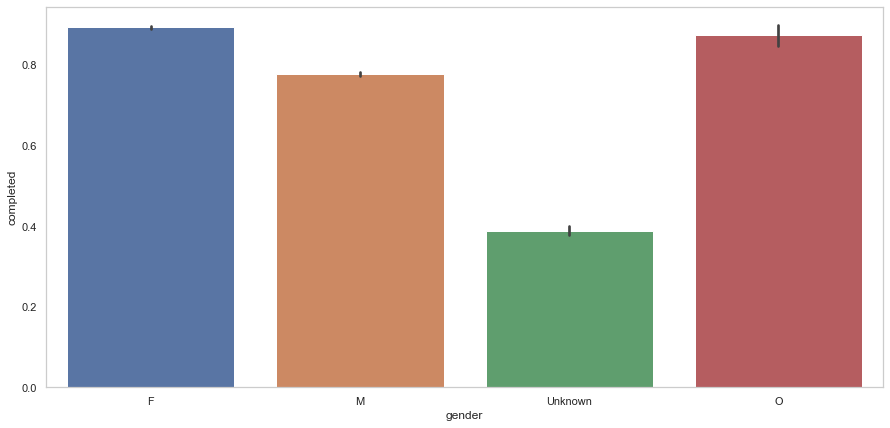

In [36]:
sns.barplot(data=df_all, x="gender", y="completed")

**Insight:** Female has generally higher completion rate then male; and customers who didnt give gender information have sigfinicantly lower completion rate than customers who gave the gender information.

- Gender & income vs offer completed

<AxesSubplot:xlabel='income', ylabel='completed'>

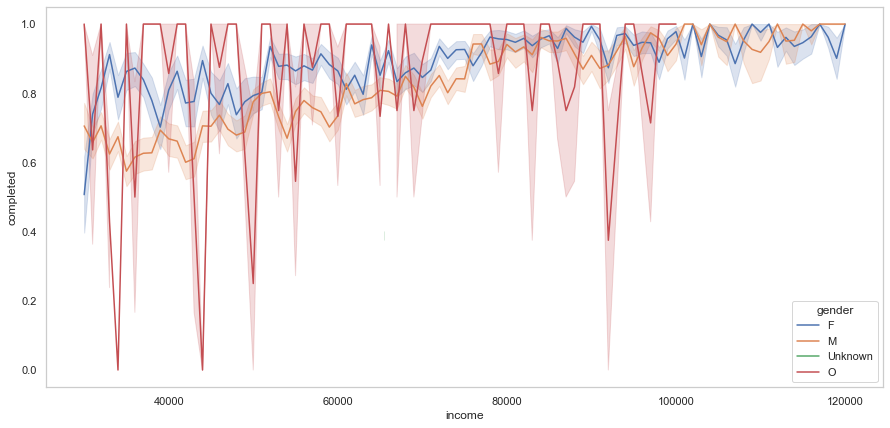

In [56]:
sns.lineplot(data=df_all, x="income", y="completed", hue="gender")

**Insight:** In the lower range of income (yearly income less tan 60000), females have higher completion ratio than males; in the higher range of income (yearly income more than 80000), females and males have the similar completion ratio.

- Relationship between reward & difficulty and offer completed

<AxesSubplot:xlabel='reward', ylabel='completed'>

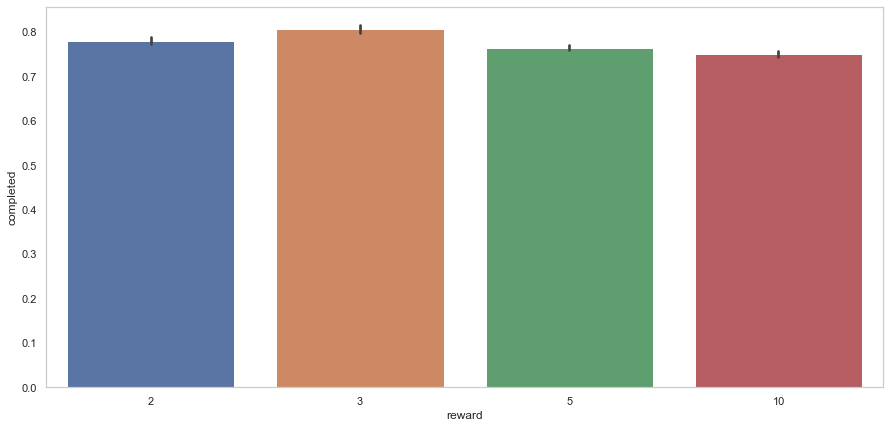

In [53]:
sns.barplot(data=df_all, x="reward", y="completed")

<AxesSubplot:xlabel='difficulty', ylabel='completed'>

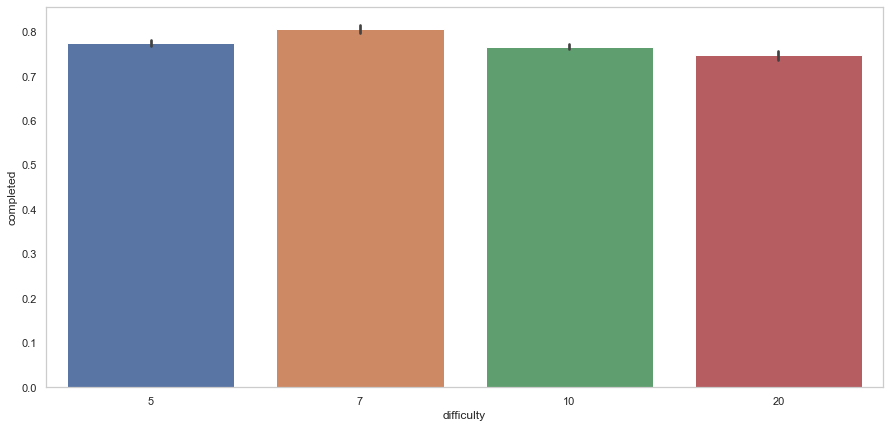

In [54]:
sns.barplot(data=df_all, x="difficulty", y="completed")

<AxesSubplot:xlabel='reward', ylabel='completed'>

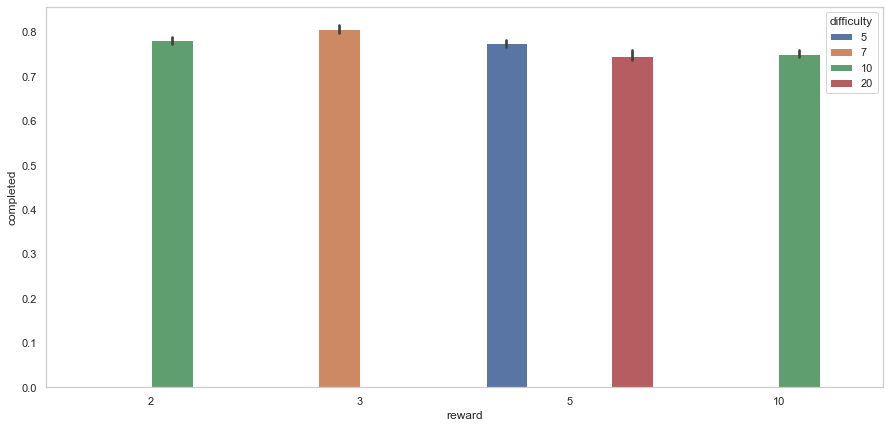

In [55]:
sns.barplot(data=df_all, x="reward", y="completed", hue='difficulty')

**Insight:** Reward with 3 and lower difficulty with 7 has the highst completion rate, while reward with 10 but with difficulty 10, and reward with 5 and difficulty with 10 have the lowest completion rate.

- Offer type vs offer completed

In [39]:
df_all.groupby('offer_type').person.count()

offer_type
bogo        25321
discount    25316
Name: person, dtype: int64

<AxesSubplot:xlabel='offer_type', ylabel='completed'>

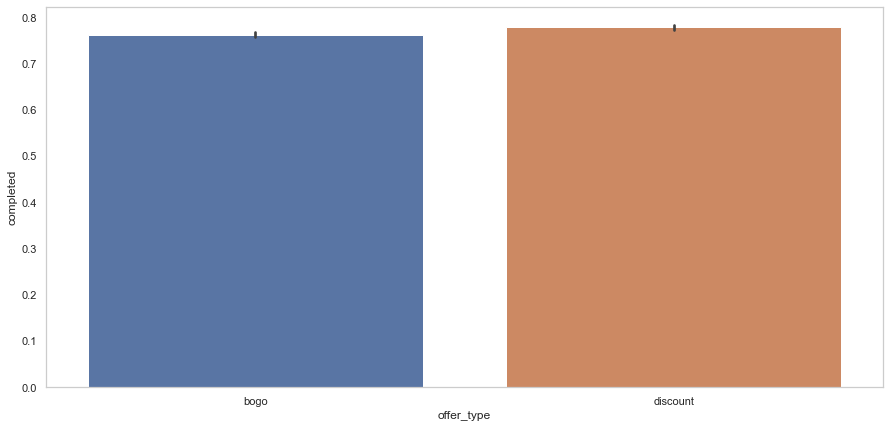

In [40]:
sns.barplot(data=df_all, x="offer_type", y="completed")

**Insight:** 'discount' offers have a slightly higher completion rate then bogo.

## ML Pipeline

This part is to use XGBoost algorithm to predict whether a customer will complete a specific offer.

In [41]:
!pip install xgboost

In [42]:
!brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> Updated Formulae
Updated 7 formulae.

To reinstall 12.0.0, run:
  brew reinstall libomp


In [43]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

- Define X(input) and Y(ountput)

In [58]:
X = df_all[[
        "gender",
        "income",
        "member_year",
        "member_month",
        "reward",
        "difficulty",
        "duration",
        "offer_type",
    ]]
Y = df_all["completed"]

### Add transaction amount!!! --> money gained
reward --> money spend

## normalize the income, reward, difficulty, duration

In [59]:
X = pd.get_dummies(X, prefix_sep="_", drop_first=True)

In [60]:
print(X.shape, Y.shape)

(50637, 10) (50637,)


- Get train & test set

In [61]:
# split data into train and test sets
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

- Train & predict 

In [62]:
# fit model no training data
model = XGBClassifier(enable_category=True)
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

/Users/ziyuan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:33:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_category" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:33:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/ziyuan/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


- Model performace evaluation

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

if len(cm) == 2:
    precision = cm[1, 1] / sum(cm[:, 1])
    recall = cm[1, 1] / sum(cm[1, :])
    f1_score = 2 * precision * recall / (precision + recall)


print(
    tabulate(
        [
            ["Accuracy", accuracy],
            ["Precision", precision],
            ["Recall", recall],
            ["f1 score", f1_score],
        ],
        headers=["Metric", "Score"],
    )
)

Metric        Score
---------  --------
Accuracy   0.809176
Precision  0.83509
Recall     0.934981
f1 score   0.882217


**Insight:** If the output is randomly guessed, the accuracy will be 50%. With an accuracy of 81%, XGBoost algorithm can be a effective tool to predict whether a specific customer will complete a specific offer.

- Importance of input features

In [65]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
gender_Unknown,0.838537
member_year,0.068224
income,0.021087
gender_M,0.018973
member_month,0.016236
reward,0.009253
offer_type_discount,0.007400
gender_O,0.006880
difficulty,0.006857


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

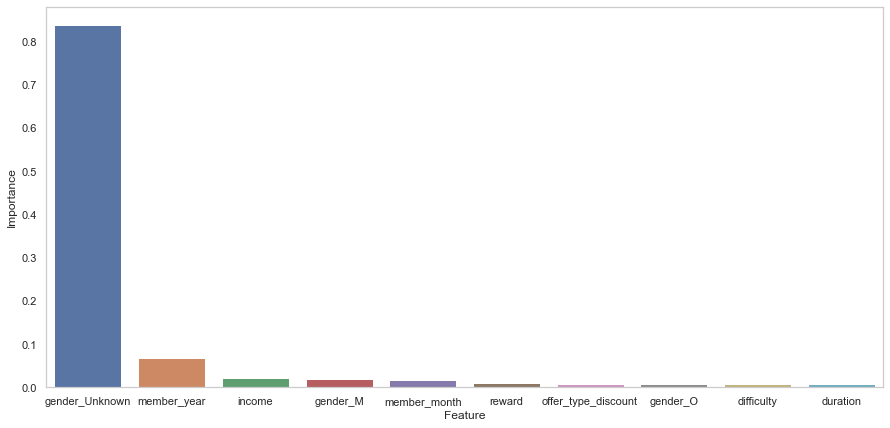

In [66]:
sns.barplot(data=importances.reset_index(level=0), x='Feature', y='Importance')

**Insights:**
Gender_unknown and member_year played the most import roles to decide whether a customer will complete an offer. This can be also reflected in the <a href="#Data Analysis">Data Analysis</a> part. Income and gender_M are followed. It is also aligned with the results in <a href="#Data Analysis">Data Analysis</a>.

### Conclusions:

- Customers who didnt give the gender information are having much lower completion rate than the customers who give this info. And the customers became member earliear and with higher income are having higher completion rate.
- With a 85% accuracy, XGBoost can be a reliable ML algorithm to predict whether a specific customer will complete a specific offer.

### Limitations

- To simply the question, the assumption that if a customer has completed a specific offer at least one time, then we say this customer will also complete this specific offer next time is made. However, this assumption can cause the bias for some features, especially the the member_year.
- 81% accuracy is definitly not the best performance of the model. Tuning the parameters of the model can improve the results.
